# 5 Making the VIDEO reference catalogues


Here we will make a video set of reference catalogues. These reference catalogues have been through many iterations.

First we calibrated against 2MASS with colour terms. We later decided to calibrate against the official VISTA catalogues.

The current decision is to calibrate each catalogue to its CASU latest release. One exception to this is the VIDEO SXDS field where we use VHS for the JHKs bands and VIDEO for the ZY bands. This was done because teh latest VIDEO release is missing some J coverage and also because we would like VHS and VIKING to be on the same photometric solution.

In [86]:
from lsst.meas.algorithms.htmIndexer import HtmIndexer
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.afw.image import abMagErrFromFluxErr, abMagFromFlux

import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.table import Table
from astropy.time import Time

import matplotlib.pyplot as plt
from collections import OrderedDict

import glob

In [2]:

PS_CATS = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/"
PS_CATS19 = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110_GmagLT19/"
EX_CAT = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/149504.fits"
EX_MS = "../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/master_schema.fits"
MASS_CAT = '../dmu0/dmu0_2MASS/data/fp_2mass.fp_psc_29182.tbl'

version = 'DR5' #HELP or DR5

VHS_CAT='../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_DR6_HSCW02_XMM.fits.gz'
VIDEO_CAT = '../dmu0/dmu0_VISTA/dmu0_VIDEO/data/vista_video_sxds_vsa.fits'
#Private HELP catalogue for comparison (Aperture fluxes not curve of growth corrected)
HELP_CAT='../dmu0/dmu0_VISTA/dmu0_VIDEO/data/VIDEO-all_2017-02-12_fullcat_errfix_v2_XMM-LSS.fits'

In [3]:
help_cat= Table.read(HELP_CAT)

In [4]:
t = Table.read(EX_CAT)

In [5]:
t[:5]

id,coord_ra,coord_dec,parent,g_flux,r_flux,i_flux,z_flux,y_flux,i_fluxSigma,y_fluxSigma,r_fluxSigma,z_fluxSigma,g_fluxSigma,coord_ra_err,coord_dec_err,epoch,pm_ra,pm_dec,pm_ra_err,pm_dec_err,footprint
,rad,rad,,,,,,,,,,,,,,,,,,,
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int64,float32,float32,float32,float32,int32
108001343677810453,2.345157026052713,-2.197806797133154e-06,0,1.2838545444537885e-06,1.982928552024532e-06,3.01517138723284e-06,4.856765372096561e-06,--,3.16738379524395e-07,--,3.629729121712444e-07,6.778826104891778e-07,3.0207684176275507e-07,0.0,0.0,1352273536,0.0,0.0,--,--,0
107431343969222916,2.345668457159465,-0.008254100378585155,0,2.007697275985265e-06,6.753069555998081e-06,1.0589669727778528e-05,1.3312220289662946e-05,2.0085879441467114e-05,5.399208475864725e-07,1.157883389169001e-06,2.962838152598124e-07,8.916217097976187e-07,3.1140803002926987e-07,0.0,0.0,1382995072,-0.0027053282,-0.023891896,0.02118348,0.02677908,0
107431343984200158,2.3456946572799193,-0.00829510768268888,0,1.884587049971742e-06,1.9010004734809627e-06,5.857659289176809e-06,8.112950126815122e-06,1.4951265256968327e-05,4.4494140638562385e-07,4.663308175167913e-07,3.0984475074546936e-07,8.782833447185112e-07,2.2170280544742127e-07,0.0,0.0,1361532032,0.07990709,-0.026615456,0.05336448,0.05336448,0
107421343990936666,2.3457072730123314,-0.008344109830567992,0,2.2955191525397822e-06,2.086113454424776e-06,5.038442850491265e-06,7.44710359867895e-06,6.868632681289455e-06,5.957058419880923e-07,1.8847487126549822e-06,2.7256422185928386e-07,5.382827339417418e-07,4.3324499188202026e-07,0.0,0.0,1393959168,-0.096279256,0.0021780662,0.070748076,0.070748076,0
107421344000032859,2.3457229088949574,-0.008399620795089824,0,2.650166607054416e-06,6.488172857643804e-06,9.41978669288801e-06,9.571983355272096e-06,1.6619222151348367e-05,4.193618394765508e-07,1.5774568282722612e-06,3.543551656548516e-07,5.85423322263523e-07,3.2145266004590667e-07,0.0,0.0,1380634624,-0.010534531,0.019350564,0.040031154,0.026171627,0


In [6]:
def getShards(ra, dec, radius):
    htm = HtmIndexer(depth=7)
    shards, onBoundary = htm.getShardIds(SpherePoint(ra*degrees, dec*degrees), radius*degrees)
    return shards
s = getShards(35.428,  -4.90777, 3.0)
s

array([133188, 133200, 133201, 133202, 133203, 133204, 133205, 133206,
       133207, 133208, 133209, 133210, 133211, 133212, 133213, 133214,
       133215, 133234, 133240, 133241, 133243, 133245, 133280, 133281,
       133282, 133283, 133288, 133289, 133291, 133293, 133294, 133295,
       133312, 133313, 133314, 133315, 133316, 133317, 133318, 133319,
       133320, 133321, 133322, 133323, 133324, 133325, 133326, 133327,
       133365, 133368, 133370, 133371, 133372, 133968, 133970, 133971,
       134024, 134048, 134049, 134050, 134051, 134052, 134053, 134054,
       134055, 134057, 134058, 134059, 134060, 134061, 134062, 134063,
       134065, 134068, 134070, 134071, 134078, 134080, 134081, 134083,
       133189, 133190, 133191, 133224, 133232, 133233, 133235, 133242,
       133244, 133246, 133247, 133268, 133285, 133286, 133287, 133290,
       133292, 133296, 133297, 133299, 133336, 133338, 133339, 133348,
       133364, 133366, 133367, 133369, 133373, 133374, 133375, 133969,
      

In [7]:
#Everything in SXDS DUD region
ps_refcats = getShards(36.,  -5.0, 3.0)
files = ''
for c in ps_refcats:
    files += '{}.fits,'.format(c)
print('scp ir-shir1@login.hpc.cam.ac.uk:~/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_PanSTARRS/data/ps1_pv3_3pi_20170110/\{'
      +files[:-1]+'\} ./')

scp ir-shir1@login.hpc.cam.ac.uk:~/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_PanSTARRS/data/ps1_pv3_3pi_20170110/\{133200.fits,133201.fits,133202.fits,133203.fits,133204.fits,133205.fits,133206.fits,133207.fits,133208.fits,133209.fits,133210.fits,133211.fits,133212.fits,133213.fits,133214.fits,133215.fits,133232.fits,133234.fits,133235.fits,133240.fits,133241.fits,133243.fits,133245.fits,133268.fits,133280.fits,133281.fits,133282.fits,133283.fits,133288.fits,133289.fits,133290.fits,133291.fits,133292.fits,133293.fits,133294.fits,133295.fits,133296.fits,133297.fits,133299.fits,133312.fits,133313.fits,133314.fits,133315.fits,133316.fits,133317.fits,133318.fits,133319.fits,133320.fits,133321.fits,133322.fits,133323.fits,133324.fits,133325.fits,133326.fits,133327.fits,133336.fits,133364.fits,133365.fits,133367.fits,133368.fits,133369.fits,133370.fits,133371.fits,133372.fits,133373.fits,133375.fits,133968.fits,134048.fits,134049.fits,134050.fits,134051.fits,134052.fits,134053.fits,1

In [8]:
def clean_table(table):
    """Take a table produced by a VO query and remove all empty columns
    
    Often many columns are empty and make the tables hard to read.
    The function also converts columsn that are objects to strings.
    Object columns prevent writing to fits.
    
    Inputs
    =======
    table,    Astropy.table.Table
        The input table
    
    Returns
    =======
    table,    Astropy.table.Table
         The modified table.
    
    """
    table = table.copy()
    if len(table) == 0:
        return table
    for col in table.colnames:
        #Remove empty columns
        try:
            if np.all(table[col].mask):
                print("Removing empty column: {}".format(col))
                table.remove_column(col)
                continue
        except AttributeError:
            pass
            #print("{} is not a masked columns".format(col))
            
        #Get rid of column type object from VO queries
        if table[col].dtype == 'object':
            print("Converting column {} type from object to string".format(col) )
            table[col] = table[col].astype(str)
 
        #Get rid of unit '-' from some tables
        if table[col].unit == '-':
            print("Converting column {} unit from '-' to None".format(col) )
            table[col].unit = None   
            
        #replace masked floats with nans     
        if (
            (table[col].dtype == float) 
            or (table[col].dtype == 'float32')
            or (table[col].dtype == 'float64')
        ):
            table[col].fill_value = np.nan
    
    table = table.filled()
            
    return table

In [9]:
# Conversion from Vega magnitudes to AB is done using values from 
# http://casu.ast.cam.ac.uk/surveys-projects/vista/technical/filter-set
# additional terms for VISTA to True Vega from Carlos Gonzalez et al.
vega_to_ab = {
    "z":0.502 + 0.004,
    "y":0.600 - 0.022,
    "j":0.916 + 0.0,
    "h":1.366 + 0.019,
    "ks":1.827 - 0.011,
    #"b118":0.853
}

In [10]:
Table.read(VIDEO_CAT).colnames

['SOURCEID',
 'CUEVENTID',
 'FRAMESETID',
 'RA',
 'DEC',
 'CX',
 'CY',
 'CZ',
 'HTMID',
 'L',
 'B',
 'LAMBDA',
 'ETA',
 'PRIORSEC',
 'ZMYPNT',
 'ZMYPNTERR',
 'YMJPNT',
 'YMJPNTERR',
 'JMHPNT',
 'JMHPNTERR',
 'HMKSPNT',
 'HMKSPNTERR',
 'ZMYEXT',
 'ZMYEXTERR',
 'YMJEXT',
 'YMJEXTERR',
 'JMHEXT',
 'JMHEXTERR',
 'HMKSEXT',
 'HMKSEXTERR',
 'MERGEDCLASSSTAT',
 'MERGEDCLASS',
 'PSTAR',
 'PGALAXY',
 'PNOISE',
 'PSATURATED',
 'EBV',
 'AZ',
 'AY',
 'AJ',
 'AH',
 'AKS',
 'ZPETROMAG',
 'ZPETROMAGERR',
 'ZKRONMAG',
 'ZKRONMAGERR',
 'ZAPERMAG3',
 'ZAPERMAG3ERR',
 'ZAPERMAG4',
 'ZAPERMAG4ERR',
 'ZAPERMAG6',
 'ZAPERMAG6ERR',
 'ZAPERMAGNOAPERCORR3',
 'ZAPERMAGNOAPERCORR4',
 'ZAPERMAGNOAPERCORR6',
 'ZHALFRAD',
 'ZHLCORSMJRADAS',
 'ZGAUSIG',
 'ZELL',
 'ZPA',
 'ZERRBITS',
 'ZCLASS',
 'ZCLASSSTAT',
 'ZPPERRBITS',
 'ZSEQNUM',
 'ZXI',
 'ZETA',
 'YPETROMAG',
 'YPETROMAGERR',
 'YKRONMAG',
 'YKRONMAGERR',
 'YAPERMAG3',
 'YAPERMAG3ERR',
 'YAPERMAG4',
 'YAPERMAG4ERR',
 'YAPERMAG6',
 'YAPERMAG6ERR',
 'YAPERMAGNOAP

In [11]:
import logging
LOGGER = logging.getLogger(__name__)
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from collections import Counter
from astropy.table import Table, Column, hstack, vstack
def merge_catalogues(cat_1, cat_2, racol_2, decol_2, radius=0.4*u.arcsec):
    """Merge two catalogues
    This function merges the second catalogue into the first one using the
    given radius to associate identical sources.  This function takes care to
    associate only one source of one catalogue to the other.  The sources that
    may be associated to various counterparts in the other catalogue are
    flagged as “maybe spurious association” with a true value in the
    flag_merged column.  If this column is present in the first catalogue, it's
    content is “inherited” during the merge.
    Parameters
    ----------
    cat_1: astropy.table.Table
        The table containing the first catalogue.  This is the master catalogue
        used during the merge.  If it has a “flag_merged” column it's content
        will be re-used in the flagging of the spurious merges.  This catalogue
        must contain a ‘ra’ and a ‘dec’ columns with the position in decimal
        degrees.
    cat_2: astropy.table.Table
        The table containing the second catalogue.
    racol_2: string
        Name of the column in the second table containing the right ascension
        in decimal degrees.
    decol_2: string
        Name of the column in the second table containing the declination in
        decimal degrees.
    radius: astropy.units.quantity.Quantity
        The radius to associate identical sources in the two catalogues.
    Returns
    -------
    astropy.table.Table
        The merged catalogue.
    """
    cat_1 = cat_1.copy()
    cat_2 = cat_2.copy()
    cat_1['ra'].unit = u.rad
    cat_1['dec'].unit = u.rad
    coords_1 = SkyCoord(cat_1['ra'], cat_1['dec'])

    
    cat_2[racol_2].unit = u.rad
    cat_2[decol_2].unit = u.rad
    coords_2 = SkyCoord(cat_2[racol_2], cat_2[decol_2])

    # Search for sources in second catalogue matching the sources in the first
    # one.
    idx_2, idx_1, d2d, _ = coords_1.search_around_sky(coords_2, radius)

    # We want to flag the possible mis-associations, i.e. the sources in each
    # catalogue that are associated to several sources in the other one, but
    # also all the sources that are associated to a problematic source in the
    # other catalogue (e.g. if two sources in the first catalogue are
    # associated to the same source in the second catalogue, they must be
    # flagged as potentially problematic).
    #
    # Search for duplicate associations
    toflag_idx_1 = np.unique([item for item, count in Counter(idx_1).items()
                              if count > 1])
    toflag_idx_2 = np.unique([item for item, count in Counter(idx_2).items()
                              if count > 1])
    # Flagging the sources associated to duplicates
    dup_associated_in_idx1 = np.in1d(idx_2, toflag_idx_2)
    dup_associated_in_idx2 = np.in1d(idx_1, toflag_idx_1)
    toflag_idx_1 = np.unique(np.concatenate(
        (toflag_idx_1, idx_1[dup_associated_in_idx1])
    ))
    toflag_idx_2 = np.unique(np.concatenate(
        (toflag_idx_2, idx_2[dup_associated_in_idx2])
    ))

    # Adding the flags to the catalogue.  In the second catalogue, the column
    # is named "flag_merged_2" and will be combined to the flag_merged column
    # one the merge is done.
    try:
        cat_1["flag_merged"] |= np.in1d(np.arange(len(cat_1), dtype=int),
                                        toflag_idx_1)
    except KeyError:
        cat_1.add_column(Column(
            data=np.in1d(np.arange(len(cat_1), dtype=int), toflag_idx_1),
            name="flag_merged"
        ))
    try:
        cat_2["flag_merged_2"] |= np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2)
    except KeyError:
        cat_2.add_column(Column(
            data=np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2),
            name="flag_merged_2"
        ))


    # Now that we have flagged the maybe spurious associations, we want to
    # associate each source of each catalogue to at most one source in the
    # other one.

    # We sort the indices by the distance to take the nearest counterparts in
    # the following steps.
    sort_idx = np.argsort(d2d)
    idx_1 = idx_1[sort_idx]
    idx_2 = idx_2[sort_idx]

    # These array will contain the indexes of the matching sources in both
    # catalogues.
    match_idx_1 = np.array([], dtype=int)
    match_idx_2 = np.array([], dtype=int)

    while len(idx_1) > 0:

        both_first_idx = np.sort(np.intersect1d(
            np.unique(idx_1, return_index=True)[1],
            np.unique(idx_2, return_index=True)[1],
        ))

        new_match_idx_1 = idx_1[both_first_idx]
        new_match_idx_2 = idx_2[both_first_idx]

        match_idx_1 = np.concatenate((match_idx_1, new_match_idx_1))
        match_idx_2 = np.concatenate((match_idx_2, new_match_idx_2))

        # We remove the matching sources in both catalogues.
        to_remove = (np.in1d(idx_1, new_match_idx_1) |
                     np.in1d(idx_2, new_match_idx_2))
        idx_1 = idx_1[~to_remove]
        idx_2 = idx_2[~to_remove]

    # Indices of un-associated object in both catalogues.
    unmatched_idx_1 = np.delete(np.arange(len(cat_1), dtype=int),match_idx_1)
    unmatched_idx_2 = np.delete(np.arange(len(cat_2), dtype=int),match_idx_2)

    # Sources only in cat_1
    only_in_cat_1 = cat_1[unmatched_idx_1]

    # Sources only in cat_2
    only_in_cat_2 = cat_2[unmatched_idx_2]
    # We are using the ra and dec columns from cat_2 for the position.
    only_in_cat_2[racol_2].name = "ra"
    only_in_cat_2[decol_2].name = "dec"

    # Merged table of sources in both catalogues.
    both_in_cat_1_and_cat_2 = hstack([cat_1[match_idx_1], cat_2[match_idx_2]])
    # We don't need the positions from the second catalogue anymore.
    both_in_cat_1_and_cat_2.remove_columns([racol_2, decol_2])

    # Logging the number of rows
    LOGGER.info("There are %s sources only in the first catalogue",
                len(only_in_cat_1))
    LOGGER.info("There are %s sources only in the second catalogue",
                len(only_in_cat_2))
    LOGGER.info("There are %s sources in both catalogues",
                len(both_in_cat_1_and_cat_2))

    merged_catalogue = vstack([only_in_cat_1, both_in_cat_1_and_cat_2,
                               only_in_cat_2])

    # When vertically stacking the catalogues, some values in the flag columns
    # are masked because they did not exist in the catalogue some row originate
    # from. We must set them to the appropriate value.
    for colname in merged_catalogue.colnames:
        if 'flag' in colname:
            merged_catalogue[colname][merged_catalogue[colname].mask] = False

    # We combined the flag_merged flags
    merged_catalogue['flag_merged'] |= merged_catalogue['flag_merged_2']
    merged_catalogue.remove_column('flag_merged_2')
    merged_catalogue.remove_column('flag_merged')
    return merged_catalogue

In [12]:
# Bands: Z,Y,J,H,K 


#This is from DR5 public reference (VEGA)
imported_columns = OrderedDict({
    'SOURCEID': "id",
    'RA': "ra",
    'DEC': "dec",
    'PSTAR':  "stellarity",

    'ZAPERMAG3': "m_ap_vista_z2", 
    'ZAPERMAG3ERR': "merr_ap_vista_z2",

    'YAPERMAG3': "m_ap_vista_y2", 
    'YAPERMAG3ERR': "merr_ap_vista_y2",

    'JAPERMAG3': "m_ap_vista_j", 
    'JAPERMAG3ERR': "merr_ap_vista_j",        

    'HAPERMAG3': "m_ap_vista_h", 
    'HAPERMAG3ERR': "merr_ap_vista_h",        

    'KSAPERMAG3': "m_ap_vista_ks", 
    'KSAPERMAG3ERR': "merr_ap_vista_ks",
})

# elif version=='HELP':
#     imported_columns = OrderedDict({
#         'ID': "id",
#         'ALPHA_J2000': "ra",
#         'DELTA_J2000': "dec",
#         'K_CLASS_STAR':  "stellarity",
#         'Z_MAG_APER_3': "m_ap_vista_z2", 
#         'Z_MAGERR_APER_3': "merr_ap_vista_z2",
#         'Y_MAG_APER_3': "m_ap_vista_y2", 
#         'Y_MAGERR_APER_3': "merr_ap_vista_y2",
#         'J_MAG_APER_3': "m_ap_vista_j", 
#         'J_MAGERR_APER_3': "merr_ap_vista_j",        
#         'H_MAG_APER_3': "m_ap_vista_h", 
#         'H_MAGERR_APER_3': "merr_ap_vista_h",        
#         'K_MAG_APER_3': "m_ap_vista_ks", 
#         'K_MAGERR_APER_3': "merr_ap_vista_ks",
#     })

catalogue = Table.read(VIDEO_CAT)[list(imported_columns)]
for column in imported_columns:
    new_col = 'video_' + imported_columns[column]
    catalogue[column].name = new_col
    catalogue[new_col].shape=(catalogue[new_col].shape[0],)
    


catalogue['video_ra'].unit = u.rad
catalogue['video_dec'].unit = u.rad
# elif version=='HELP':
#     catalogue['video_ra'].unit = u.deg
#     catalogue['video_dec'].unit = u.deg
#     catalogue['video_ra'].convert_unit_to(u.rad)
#     catalogue['video_dec'].convert_unit_to(u.rad)

for col in catalogue.colnames:
    if col.startswith('video_m_ap'):
        print(col)
        mask = catalogue[col] <= 0
        mask |= catalogue[col] >  30
        catalogue[col][mask] = np.nan
        catalogue[col.replace('video_m', 'video_merr')][mask] = np.nan
        
        
        # Convert magnitude from Vega to AB
        before = np.nanmean(catalogue[col])
        catalogue[col] += vega_to_ab[col.split('_')[-1].replace('2', '')]
        print(col, vega_to_ab[col.split('_')[-1].replace('2', '')], np.nanmean(catalogue[col])-before)
#         elif version=='HELP':
#             print('HELP not AB corrected as already AB')
#v_flux = Table.read('../dmu0/dmu0_VISTA/dmu0_VHS/data/VHS_XMM-LSS.fits')
#v_flux = catalogue[catalogue['video_stellarity'] >= 0.9]
v_flux = catalogue

video_m_ap_vista_z2
video_m_ap_vista_z2 0.506 0.5060005
video_m_ap_vista_y2
video_m_ap_vista_y2 0.578 0.57800674
video_m_ap_vista_j
video_m_ap_vista_j 0.916 0.91599655
video_m_ap_vista_h
video_m_ap_vista_h 1.385 1.3849907
video_m_ap_vista_ks
video_m_ap_vista_ks 1.816 1.8160019


In [13]:
print(len(catalogue),
      np.sum(catalogue['video_stellarity'] >= 0.01), 
      np.sum(catalogue['video_stellarity'] >= 0.1), 
      np.sum(catalogue['video_stellarity'] >= 0.5), 
      np.sum(catalogue['video_stellarity'] >= 0.9), )

1335572 1049498 578814 17781 7104


In [14]:
# Bands: Z,Y,J,H,K 


#This is from DR6 public reference (VEGA)
vhs_imported_columns = OrderedDict({
    'SOURCEID': "id",
    'RA': "ra",
    'DEC': "dec",
    'PSTAR':  "stellarity",

#     'ZAPERMAG3': "m_ap_vista_z2", 
#     'ZAPERMAG3ERR': "merr_ap_vista_z2",

#     'YAPERMAG3': "m_ap_vista_y2", 
#     'YAPERMAG3ERR': "merr_ap_vista_y2",

    'JAPERMAG3': "m_ap_vista_j", 
    'JAPERMAG3ERR': "merr_ap_vista_j",        

    'HAPERMAG3': "m_ap_vista_h", 
    'HAPERMAG3ERR': "merr_ap_vista_h",        

    'KSAPERMAG3': "m_ap_vista_ks", 
    'KSAPERMAG3ERR': "merr_ap_vista_ks",
})



vhs_catalogue = Table.read(VHS_CAT)[list(vhs_imported_columns)]
for column in vhs_imported_columns:
    new_col = 'vhs_' + vhs_imported_columns[column]
    vhs_catalogue[column].name = new_col
    vhs_catalogue[new_col].shape=(vhs_catalogue[new_col].shape[0],)
vhs_catalogue['vhs_ra'].unit = u.rad
vhs_catalogue['vhs_dec'].unit = u.rad

for col in vhs_catalogue.colnames:
    if col.startswith('vhs_m_ap'):
        print(col)
        mask = vhs_catalogue[col] <= 0
        mask |= vhs_catalogue[col] >  30
        vhs_catalogue[col][mask] = np.nan
        vhs_catalogue[col.replace('vhs_m', 'vhs_merr')][mask] = np.nan
        
        
        # Convert magnitude from Vega to AB
        before = np.nanmean(vhs_catalogue[col])
        vhs_catalogue[col] += vega_to_ab[col.split('_')[-1].replace('2', '')]
        print(col, vega_to_ab[col.split('_')[-1].replace('2', '')], np.nanmean(vhs_catalogue[col])-before)

vhs_flux = vhs_catalogue

vhs_m_ap_vista_j
vhs_m_ap_vista_j 0.916 0.9159908
vhs_m_ap_vista_h
vhs_m_ap_vista_h 1.385 1.3849964
vhs_m_ap_vista_ks
vhs_m_ap_vista_ks 1.816 1.8159943


In [15]:
v_flux[:5]

video_id,video_ra,video_dec,video_stellarity,video_m_ap_vista_z2,video_merr_ap_vista_z2,video_m_ap_vista_y2,video_merr_ap_vista_y2,video_m_ap_vista_j,video_merr_ap_vista_j,video_m_ap_vista_h,video_merr_ap_vista_h,video_m_ap_vista_ks,video_merr_ap_vista_ks
,rad,rad,,,,,,,,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
644245094401,0.637146247344493,-0.09567500449116101,0.25,22.345537,0.7281855,nan,nan,nan,nan,nan,nan,nan,nan
644245094402,0.6354953838665087,-0.09567249869519337,0.05247814,21.797901,0.343822,21.337627,0.39588535,nan,nan,21.274355,0.2625665,nan,nan
644245094403,0.63649260890939,-0.09567343077979626,0.13454352,20.94445,0.35480428,20.52083,0.53092974,nan,nan,19.909168,0.19337006,19.532896,0.10309691
644245094404,0.6424034130805547,-0.09567197988709318,0.0085626915,20.795221,0.4907004,20.585878,0.5666199,nan,nan,20.841366,0.2981397,nan,nan
644245094405,0.6372880057895218,-0.09567162793453408,0.7346939,22.134047,0.325958,21.59976,0.47674987,nan,nan,21.30466,0.17866063,nan,nan


In [16]:
vhs_flux[:5]

vhs_id,vhs_ra,vhs_dec,vhs_stellarity,vhs_m_ap_vista_j,vhs_merr_ap_vista_j,vhs_m_ap_vista_h,vhs_merr_ap_vista_h,vhs_m_ap_vista_ks,vhs_merr_ap_vista_ks
,rad,rad,,,,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32
472478420689,0.5313506138107422,0.02441398961306191,0.9,21.000256,0.25536814,nan,nan,nan,nan
472478420678,0.5346928341588668,0.02443321697338387,0.00017140902,20.061094,0.10981393,20.0059,0.16131267,19.713032,0.16325213
472478420677,0.5322687499760828,0.024426932772583718,0.9,20.851288,0.23619072,nan,nan,nan,nan
472478420674,0.5330263594316909,0.02443767892020007,0.00017140902,20.244732,0.13296393,19.94293,0.15068679,19.895264,0.19767918
472478420672,0.533468198257412,0.02443463076215464,0.9,20.81285,0.21036822,nan,nan,nan,nan


In [17]:
v_flux['ra']=v_flux['video_ra']
v_flux['dec']=v_flux['video_dec']
vhs_flux['vhs_ra_temp']=vhs_flux['vhs_ra']
vhs_flux['vhs_dec_temp']=vhs_flux['vhs_dec']
vhs_vid_merge=merge_catalogues(v_flux, vhs_flux, 'vhs_ra_temp', 'vhs_dec_temp', radius=0.6*u.arcsec)
for c in vhs_vid_merge.colnames:
    if str(vhs_vid_merge[c].dtype).startswith('float'):
        vhs_vid_merge[c].fill_value=np.nan
vhs_vid_merge=vhs_vid_merge.filled()

In [18]:
vhs_vid_merge[:5]

video_id,video_ra,video_dec,video_stellarity,video_m_ap_vista_z2,video_merr_ap_vista_z2,video_m_ap_vista_y2,video_merr_ap_vista_y2,video_m_ap_vista_j,video_merr_ap_vista_j,video_m_ap_vista_h,video_merr_ap_vista_h,video_m_ap_vista_ks,video_merr_ap_vista_ks,ra,dec,vhs_id,vhs_ra,vhs_dec,vhs_stellarity,vhs_m_ap_vista_j,vhs_merr_ap_vista_j,vhs_m_ap_vista_h,vhs_merr_ap_vista_h,vhs_m_ap_vista_ks,vhs_merr_ap_vista_ks
,rad,rad,,,,,,,,,,,,rad,rad,,rad,rad,,,,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,int64,float64,float64,float32,float32,float32,float32,float32,float32,float32
644245094401,0.637146247344493,-0.09567500449116101,0.25,22.345537,0.7281855,nan,nan,nan,nan,nan,nan,nan,nan,0.637146247344493,-0.09567500449116101,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan
644245094402,0.6354953838665087,-0.09567249869519337,0.05247814,21.797901,0.343822,21.337627,0.39588535,nan,nan,21.274355,0.2625665,nan,nan,0.6354953838665087,-0.09567249869519337,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan
644245094405,0.6372880057895218,-0.09567162793453408,0.7346939,22.134047,0.325958,21.59976,0.47674987,nan,nan,21.30466,0.17866063,nan,nan,0.6372880057895218,-0.09567162793453408,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan
644245094406,0.6362464252499593,-0.09566830617967831,0.7,23.373491,0.5171232,nan,nan,nan,nan,nan,nan,nan,nan,0.6362464252499593,-0.09566830617967831,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan
644245094407,0.6342156111783251,-0.09566810249673985,0.7,22.556137,0.4188552,nan,nan,nan,nan,nan,nan,nan,nan,0.6342156111783251,-0.09566810249673985,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan


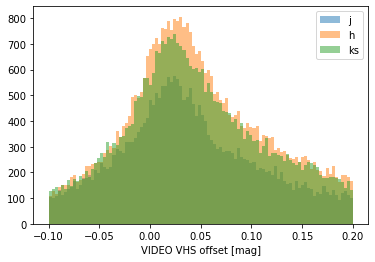

In [19]:
bins=100
r=[-0.1,0.2]
for b in ['j','h','ks']:
    plt.hist(
        vhs_vid_merge['vhs_m_ap_vista_'+b]-vhs_vid_merge['video_m_ap_vista_'+b],
        bins=bins,range=r,alpha=0.5,label=b)
    plt.xlabel('VIDEO VHS offset [mag]')
plt.legend()

In [20]:
vhs_area=(
    np.nanmax(vhs_vid_merge['vhs_ra'])-np.nanmin(vhs_vid_merge['vhs_ra'])
)*(
    np.nanmax(vhs_vid_merge['vhs_dec'])-np.nanmin(vhs_vid_merge['vhs_dec'])
)
vid_area=(
    np.nanmax(vhs_vid_merge['video_ra'])-np.nanmin(vhs_vid_merge['video_ra'])
)*(
    np.nanmax(vhs_vid_merge['video_dec'])-np.nanmin(vhs_vid_merge['video_dec'])
)
vhs_area/vid_area

23.645730760724568

In [21]:
print('Total objects:',len(vhs_vid_merge))
print('Objects without VIDEO detection:',np.sum(~np.isnan(vhs_vid_merge['video_ra'])))
print('Objects without VHS detection:',np.sum(~np.isnan(vhs_vid_merge['vhs_ra'])))
print('Objects in both:',np.sum((~np.isnan(vhs_vid_merge['vhs_ra']))&(~np.isnan(vhs_vid_merge['video_ra']))))
#Keep only VIDEO objects
vhs_vid_merge=vhs_vid_merge[~np.isnan(vhs_vid_merge['video_ra'])]
# replace video JHKs with VHS
for b in ['j','h','ks']:
    mask=np.isnan(vhs_vid_merge['video_m_ap_vista_'+b])
    vhs_vid_merge[mask]['video_m_ap_vista_'+b]=vhs_vid_merge[mask]['vhs_m_ap_vista_'+b]
    vhs_vid_merge[mask]['video_merr_ap_vista_'+b]=vhs_vid_merge[mask]['vhs_merr_ap_vista_'+b]
#remove vhs columns
for c in vhs_vid_merge.colnames:
    if c.startswith('vhs_'):
        vhs_vid_merge.remove_column(c)
print('Total objects:',len(vhs_vid_merge))

Total objects: 3569321
Objects without VIDEO detection: 1335572
Objects without VHS detection: 2295799
Objects in both: 62050
Total objects: 1335572


Text(0.5, 0, 'VIDEO DR5 VSA PSTAR')

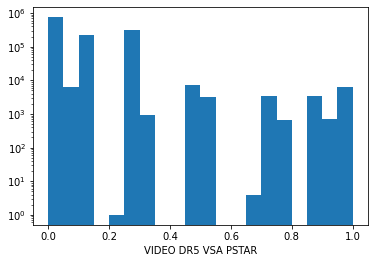

In [22]:
plt.hist(catalogue['video_stellarity'],bins=20 )
plt.yscale('log')
plt.xlabel('VIDEO DR5 VSA PSTAR')

Text(0.5, 0, 'HELP private VIDEO K_CLASS_STAR')

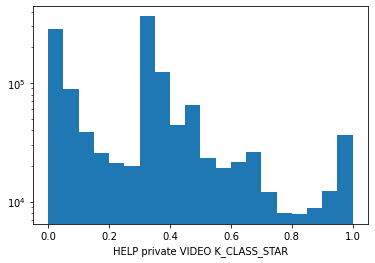

In [23]:
plt.hist(help_cat['K_CLASS_STAR'],bins=20 )
plt.yscale('log')
plt.xlabel('HELP private VIDEO K_CLASS_STAR')

In [24]:
for key in vega_to_ab:
    print(key,np.sum(np.isnan(v_flux[
        'video_m_ap_vista_{}'.format(
        key.replace('z','z2').replace('y','y2'))
    ])))

z 501117
y 326730
j 710925
h 543378
ks 636901


Text(0, 0.5, 'Dec [rad]')

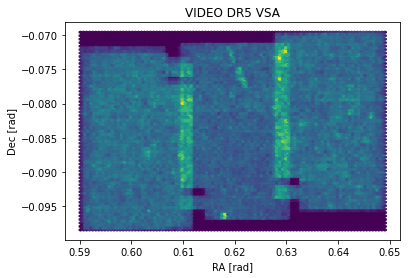

In [25]:
plt.hexbin(v_flux['video_ra'],v_flux['video_dec'],rasterized=True)
plt.title('VIDEO DR5 VSA')
plt.xlabel('RA [rad]')
plt.ylabel('Dec [rad]')

In [112]:
tempMask=~np.isnan(v_flux['video_m_ap_vista_ks'])
plt.hexbin(v_flux[tempMask]['video_ra'],v_flux[tempMask]['video_dec'],rasterized=True)
plt.title('VIDEO DR5 J detections VSA')
plt.xlabel('RA [rad]')
plt.ylabel('Dec [rad]')

KeyError: 'video_m_ap_vista_z'

There are no J fluxes in one of the pointings

Text(0, 0.5, 'Dec [rad]')

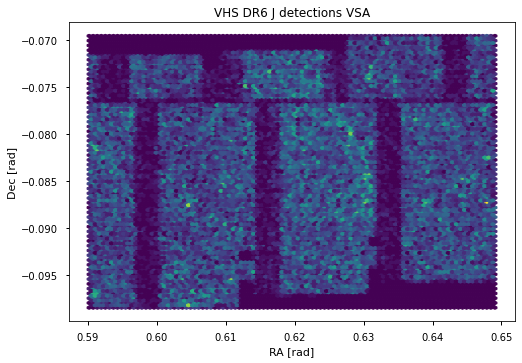

In [108]:
tempMask=~np.isnan(vhs_vid_merge['video_m_ap_vista_ks'])
plt.hexbin(vhs_vid_merge[tempMask]['video_ra'],vhs_vid_merge[tempMask]['video_dec'],rasterized=True)
plt.title('VHS DR6 J detections VSA')
plt.xlabel('RA [rad]')
plt.ylabel('Dec [rad]')

In [28]:
np.sum(~np.isnan(vhs_vid_merge['video_m_ap_vista_j']))

51317

Text(0, 0.5, 'Dec [deg]')

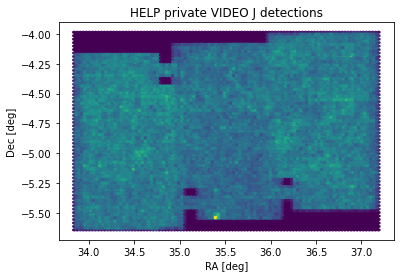

In [29]:
tempMask=(help_cat['J_MAG_APER_3']>10) & (help_cat['J_MAG_APER_3']<30)
plt.hexbin(help_cat[tempMask]['ALPHA_J2000'],help_cat[tempMask]['DELTA_J2000'],rasterized=True)
plt.title('HELP private VIDEO J detections')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')

In [30]:
np.sum(np.isnan(v_flux['video_m_ap_vista_j']))

710925

In [31]:
print(np.sum(catalogue['video_stellarity'] >= 0.9),np.sum(help_cat['K_CLASS_STAR'] >= 0.9))

7104 48616


In [32]:
print(len(catalogue),len(help_cat))

1335572 1253838


In [33]:
v_flux[:5]

video_id,video_ra,video_dec,video_stellarity,video_m_ap_vista_z2,video_merr_ap_vista_z2,video_m_ap_vista_y2,video_merr_ap_vista_y2,video_m_ap_vista_j,video_merr_ap_vista_j,video_m_ap_vista_h,video_merr_ap_vista_h,video_m_ap_vista_ks,video_merr_ap_vista_ks,ra,dec
,rad,rad,,,,,,,,,,,,rad,rad
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64
644245094401,0.637146247344493,-0.09567500449116101,0.25,22.345537,0.7281855,nan,nan,nan,nan,nan,nan,nan,nan,0.637146247344493,-0.09567500449116101
644245094402,0.6354953838665087,-0.09567249869519337,0.05247814,21.797901,0.343822,21.337627,0.39588535,nan,nan,21.274355,0.2625665,nan,nan,0.6354953838665087,-0.09567249869519337
644245094403,0.63649260890939,-0.09567343077979626,0.13454352,20.94445,0.35480428,20.52083,0.53092974,nan,nan,19.909168,0.19337006,19.532896,0.10309691,0.63649260890939,-0.09567343077979626
644245094404,0.6424034130805547,-0.09567197988709318,0.0085626915,20.795221,0.4907004,20.585878,0.5666199,nan,nan,20.841366,0.2981397,nan,nan,0.6424034130805547,-0.09567197988709318
644245094405,0.6372880057895218,-0.09567162793453408,0.7346939,22.134047,0.325958,21.59976,0.47674987,nan,nan,21.30466,0.17866063,nan,nan,0.6372880057895218,-0.09567162793453408


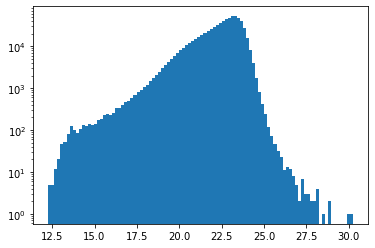

In [34]:
plt.hist(v_flux['video_m_ap_vista_ks'], bins=100)
plt.yscale('log')

In [35]:
np.sum(~np.isnan(v_flux['video_m_ap_vista_ks']))

698671

In [36]:
import astropy.units as u

In [37]:
import astropy.units as u
for col in v_flux.colnames:
    if col.startswith('f'):
        v_flux[col] /= 1.E6
        v_flux[col].unit = u.Jansky


In [38]:
v_flux['video_ra'].unit = u.rad
v_flux['video_dec'].unit = u.rad
v_flux['video_ra'].convert_unit_to(u.rad)
v_flux['video_dec'].convert_unit_to(u.rad)
#v_flux['ra'].name = 'v_ra'
#v_flux['dec'].name = 'v_dec'

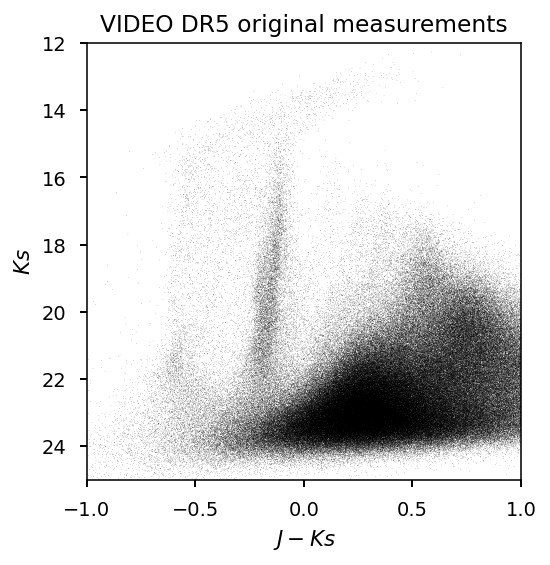

In [39]:
import matplotlib.pyplot as plt
#selected = v_flux['f_vista_y'] / v_flux['ferr_vista_y'] > 5
#selected &= v_flux['f_vista_ks'] / v_flux['ferr_vista_ks'] > 5
plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(v_flux['video_m_ap_vista_j'] - v_flux['video_m_ap_vista_ks'],
            v_flux['video_m_ap_vista_ks'],
            edgecolors='None', s=0.05, c='k', rasterized=True)
plt.xlim(-1, 1)
plt.ylim(25, 12)
plt.xlabel('$J-Ks$')
plt.ylabel('$Ks$')
plt.title('VIDEO DR5 original measurements')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

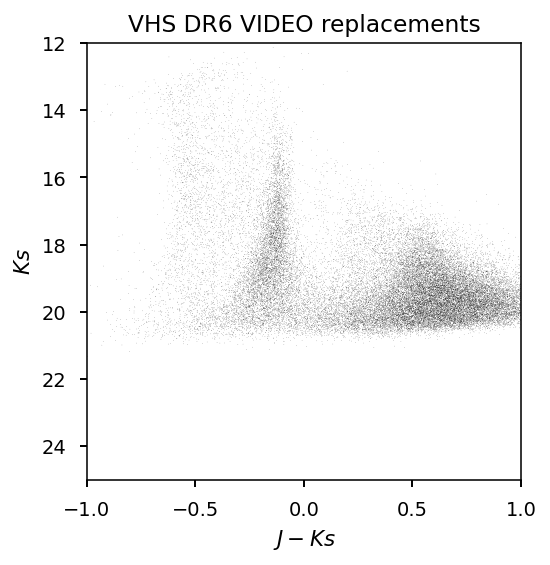

In [40]:
import matplotlib.pyplot as plt
#selected = v_flux['f_vista_y'] / v_flux['ferr_vista_y'] > 5
#selected &= v_flux['f_vista_ks'] / v_flux['ferr_vista_ks'] > 5
plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter(vhs_vid_merge['video_m_ap_vista_j'] - vhs_vid_merge['video_m_ap_vista_ks'],
            vhs_vid_merge['video_m_ap_vista_ks'],
            edgecolors='None', s=0.05, c='k', rasterized=True)
plt.xlim(-1, 1)
plt.ylim(25, 12)
plt.xlabel('$J-Ks$')
plt.ylabel('$Ks$')
plt.title('VHS DR6 VIDEO replacements')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

In [41]:
r_cat = Table.read(EX_CAT)

In [42]:
#Delete old folder
!rm -r ./data/ref_cats_video/
!mkdir -p ./data/ref_cats_video/

In [43]:
#USE CATALOGUE with VHS replacements
v_flux=vhs_vid_merge
v_flux.remove_columns(['ra','dec'])

In [44]:
#VIDEO REF CAT
n_video=0
n_tot=0
total_cat=Table()
for c in ps_refcats:
    r_cat = Table.read("../dmu0/dmu0_PanStarrs/data/ps1_pv3_3pi_20170110/{}.fits".format(c))
    r_cat['coord_ra'].name = 'ra'
    r_cat['coord_dec'].name = 'dec'
    merge = merge_catalogues(r_cat, v_flux, 'video_ra', 'video_dec', radius=0.8*u.arcsec)
    merge=clean_table(merge)
    has_both  = (
        (merge['g_flux'] >0.)
        # &(merge['video_m_ap_vista_ks']>0.) #Take all panstarrs objects
    )

    merge = merge[has_both]
    
    if np.sum(~np.isnan(merge['video_m_ap_vista_ks'])) == 0:
        #print('No VIDEO objects in {}'.format(c))
        continue
    
    
    merge['ra'].name = 'coord_ra'
    merge['dec'].name = 'coord_dec'
    #convert rad to degs?
    merge['coord_ra'] = (180./np.pi)*merge['coord_ra']
    merge['coord_ra'].unit = u.deg
    merge['coord_dec'] = (180./np.pi)*merge['coord_dec']
    merge['coord_dec'].unit = u.deg
    
    removePm=True
    if removePm:
        merge['pm_ra']=0
        merge['pm_dec']=0
        merge['pm_ra_err']=0
        merge['pm_dec_err']=0
    else
        merge['pm_ra'].unit=u.marcsec/u.year
        merge['pm_dec'].unit=u.marcsec/u.year
        merge['pm_ra_err'].unit=u.marcsec/u.year
        merge['pm_dec_err'].unit=u.marcsec/u.year
    
    merge['pm_ra_err'].name = 'pm_raErr'
    merge['pm_dec_err'].name = 'pm_decErr'
    try:
        merge['coord_raErr'] = (180./np.pi)*merge['coord_ra_err']
        merge['coord_raErr'].unit = u.deg
        merge['coord_decErr'] = (180./np.pi)*merge['coord_dec_err']
        merge['coord_decErr'].unit = u.deg
        merge.remove_columns['coord_ra_err', 'coord_dec_err']
    except:
        merge['coord_raErr'] = (180./np.pi)*merge['coord_raErr']
        merge['coord_raErr'].unit = u.deg
        merge['coord_decErr'] = (180./np.pi)*merge['coord_decErr']
        merge['coord_decErr'].unit = u.deg
    #flags col only in James Mulaney 19 cut cat
    #merge['flags'].format = '1X'
    merge['epoch'] = merge['epoch'].astype('int32')
    #merge[has_both].write('./data/refcats/{}.fits'.format(c), overwrite=True)
    
    for col in merge.colnames:
        #go through every flux column and convert to mags and rename
        if col.endswith('_flux'):
            err_col = col + 'Sigma'
            mag = abMagFromFlux(merge[col])
            mag_err = abMagErrFromFluxErr(merge[err_col],merge[col])
            merge[col] = mag
            merge[col].name = col[:-5]
            merge[err_col] = mag_err
            merge[err_col].name = err_col.replace('fluxSigma','err')
        #Go through every video mag col and rename
        if col.startswith('video_m_'):
            #Leave just band and replace z/y with z2/y2
            merge[col].name = col.split('_')[-1]
           
            merge[col.replace('video_m_', 'video_merr_')].name =  col.split('_')[-1] + '_err'
    merge.remove_columns(['video_stellarity', 'video_id'])
    merge.write('./data/ref_cats_video/{}.fits'.format(c), overwrite=True)
    total_cat=vstack([total_cat,merge])
    print("Shard {} has {} objects and {} VIDEO mags.".format(c, len(merge), np.sum(~np.isnan(merge['ks']))))
    n_video+=np.sum(~np.isnan(merge['ks']))
    n_tot+=len(merge)

Shard 133200 has 12877 objects and 963 VIDEO mags.


Shard 133201 has 12581 objects and 3035 VIDEO mags.


Shard 133202 has 14150 objects and 2212 VIDEO mags.


Shard 133203 has 13422 objects and 1493 VIDEO mags.


Shard 133206 has 13264 objects and 1225 VIDEO mags.


Shard 133209 has 11969 objects and 555 VIDEO mags.


Shard 133213 has 14287 objects and 1657 VIDEO mags.


Shard 133214 has 12922 objects and 2220 VIDEO mags.


Shard 133215 has 12812 objects and 1277 VIDEO mags.


Shard 133312 has 14458 objects and 236 VIDEO mags.


Shard 133313 has 12464 objects and 28 VIDEO mags.


Shard 133314 has 12578 objects and 2715 VIDEO mags.


Shard 133315 has 11994 objects and 1374 VIDEO mags.


Shard 133317 has 12708 objects and 490 VIDEO mags.


Shard 133318 has 11838 objects and 87 VIDEO mags.


Shard 133319 has 12184 objects and 313 VIDEO mags.


Shard 133321 has 12893 objects and 2104 VIDEO mags.


Shard 133322 has 12242 objects and 990 VIDEO mags.


Shard 133323 has 12732 objects and 913 VIDEO mags.


Shard 133324 has 13102 objects and 2159 VIDEO mags.


Shard 133325 has 11827 objects and 1560 VIDEO mags.


Shard 133326 has 12502 objects and 671 VIDEO mags.


Shard 133327 has 12411 objects and 2653 VIDEO mags.


Shard 134048 has 14950 objects and 567 VIDEO mags.


Shard 134049 has 12129 objects and 2218 VIDEO mags.


Shard 134050 has 13738 objects and 452 VIDEO mags.


Shard 134051 has 13119 objects and 1339 VIDEO mags.


Shard 134053 has 12708 objects and 303 VIDEO mags.


Shard 134054 has 11533 objects and 1917 VIDEO mags.


Shard 134055 has 13430 objects and 456 VIDEO mags.


Shard 134060 has 11747 objects and 114 VIDEO mags.


Shard 134061 has 13593 objects and 496 VIDEO mags.


Shard 134062 has 11704 objects and 1872 VIDEO mags.


Shard 134063 has 13020 objects and 1359 VIDEO mags.


In [45]:
n_video,n_tot

(42023, 435888)

In [46]:
len(total_cat)

435888

In [47]:
total_cat[:5]

id,coord_ra,coord_dec,parent,g,r,i,z,y,i_err,y_err,r_err,z_err,g_err,coord_ra_err,coord_dec_err,epoch,pm_ra,pm_dec,pm_raErr,pm_decErr,footprint,z2,z2_err,y2,y2_err,j,j_err,h,h_err,ks,ks_err,coord_raErr,coord_decErr
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
101240348719679131,34.872000500259766,-5.6260778101412985,0,23.184826381773323,23.08681973437381,22.62273782291056,23.0104303728167,20.56244854319749,0.3220554294531736,0.20988879044150155,0.5020276795463325,0.08328634183787527,0.11316483615715915,0.0,0.0,1380287232,0.0,0.0,0.0,0.0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
101220348728797983,34.87293013703126,-5.643699732046367,0,23.206315040142886,21.613636020356253,20.94146485382259,20.748910842583385,20.38352723907499,0.03108193830196016,0.0724149187422211,0.08042308304672052,0.04306769529453557,0.36502200451003547,0.0,0.0,1363572864,0.0,0.0,0.0,0.0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
101220348739597084,34.87398615001206,-5.644378751618471,0,22.774808414089264,21.46113159738162,19.76586692425524,18.961333057134826,18.59359977313514,0.009793262080674723,0.008706714569025956,0.05192713968125531,0.015864659220396253,0.15705289932506117,0.0,0.0,1418507264,0.0,0.0,0.0,0.0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
101220348741624889,34.87410841480648,-5.646210905382951,0,22.286558182988735,20.94030136581887,20.182583306735392,20.082292588099804,19.643675099929734,0.022906742447986725,0.0735857955340432,0.06454815476264517,0.04087187638674613,0.11304534118616623,0.0,0.0,1359415936,0.0,0.0,0.0,0.0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0
101240348762542463,34.876366705092465,-5.631525179127517,0,23.790056670535993,21.607263137363894,23.070616698190534,22.553486844146185,21.195950556571077,0.26535337691927924,0.46639627721193605,1.0310838977158492,0.20639394170790967,0.3071523894508719,0.0,0.0,1287234816,0.0,0.0,0.0,0.0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0


In [48]:
for b in ['z2','y2','j','h','ks']:
    print(b, np.sum(~np.isnan(total_cat[b])))

z2 114092
y2 174551
j 47549
h 45959
ks 42023


# Gen 3 format

It is still unclear what form the gen 3 reference catalogeus should be in as there is no gen 3 ingest task available yet. Looking at the obs_necam example they appear to be in Jansky units not nanojansky as I think the originals were.

In [49]:
import glob
ingested =glob.glob('./data/ref_cats_video_ingested/ref_cats/cal_ref_cat/*.fits')

In [103]:
ingested

['./data/ref_cats_video_ingested/ref_cats/cal_ref_cat/134060.fits',
 './data/ref_cats_video_ingested/ref_cats/cal_ref_cat/133317.fits',
 './data/ref_cats_video_ingested/ref_cats/cal_ref_cat/133213.fits',
 './data/ref_cats_video_ingested/ref_cats/cal_ref_cat/133321.fits',
 './data/ref_cats_video_ingested/ref_cats/cal_ref_cat/134061.fits',
 './data/ref_cats_video_ingested/ref_cats/cal_ref_cat/133209.fits',
 './data/ref_cats_video_ingested/ref_cats/cal_ref_cat/133214.fits',
 './data/ref_cats_video_ingested/ref_cats/cal_ref_cat/133202.fits',
 './data/ref_cats_video_ingested/ref_cats/cal_ref_cat/134050.fits',
 './data/ref_cats_video_ingested/ref_cats/cal_ref_cat/master_schema.fits',
 './data/ref_cats_video_ingested/ref_cats/cal_ref_cat/133326.fits',
 './data/ref_cats_video_ingested/ref_cats/cal_ref_cat/133327.fits',
 './data/ref_cats_video_ingested/ref_cats/cal_ref_cat/134051.fits',
 './data/ref_cats_video_ingested/ref_cats/cal_ref_cat/133203.fits',
 './data/ref_cats_video_ingested/ref_cats

In [51]:
!mkdir data/ref_cats_gen3_test/

mkdir: data/ref_cats_gen3_test/: File exists


In [125]:
for t in ingested:
    name=t.split('/')[-1]
    print(name)
    #t=Table.read(t)
    t=fits.open(t)
    for c in t[1].columns:
        n = c.name
        #if 'flux' in n:
            #t[n]
            
        if n.startswith('pm_'):
            #t[n].unit=u.rad/u.year
            #t[n].convert_unit_to(u.marcsec/u.year)
            #t[1].data[n]=0
            pass
        
    #Gen 3 expects mjd epoch not unix - was leading to astrometry failure
    t[1].data['epoch']=Time(t[1].data['epoch'],format='unix').mjd
            
    t.writeto('./data/ref_cats_gen3_test/{}'.format(name),overwrite=True)

134060.fits
133317.fits
133213.fits
133321.fits
134061.fits
133209.fits
133214.fits
133202.fits
134050.fits
master_schema.fits
133326.fits
133327.fits
134051.fits
133203.fits
133215.fits
133312.fits
133200.fits
133324.fits
134048.fits
134049.fits
133325.fits
133201.fits
133313.fits
134053.fits
133322.fits
134062.fits
133318.fits
134054.fits
133314.fits
133206.fits
133315.fits
134055.fits
134063.fits
133319.fits
133323.fits


In [59]:
ingested[0]

'./data/ref_cats_video_ingested/ref_cats/cal_ref_cat/134060.fits'

In [60]:
from astropy.io import fits
n=fits.open(ingested[0])
m=n[1]

In [70]:
#m=n[1]
m.data['pm_ra']=0

In [89]:
Time(m.data['epoch'],format='unix').mjd

TypeError: only size-1 arrays can be converted to Python scalars

In [102]:
u.day


Unit("d")

In [96]:
asT=Table(t[1].data)
mask=asT['pm_ra']>0
asT[mask][:5]

flags [1],id,coord_ra,coord_dec,g_flux,r_flux,i_flux,z_flux,y_flux,z2_flux,y2_flux,j_flux,h_flux,ks_flux,g_fluxErr,r_fluxErr,i_fluxErr,z_fluxErr,y_fluxErr,z2_fluxErr,y2_fluxErr,j_fluxErr,h_fluxErr,ks_fluxErr,coord_raErr,coord_decErr,epoch,pm_ra,pm_dec,pm_raErr,pm_decErr,parent,footprint
bool,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float32,float32,int64,int32
False,103410366270601102,0.6392631655361942,-0.0667492985446858,3472.4166507806603,6930.302728223304,15462.785442188862,23632.619058683747,27660.362119220797,nan,nan,nan,nan,nan,291.1880017109074,500.7672712054054,340.155821731967,513.0160047883699,1602.7753417802153,nan,nan,nan,nan,nan,0.0,0.0,56177.974814814814,6.67737217815427e-11,1.9781168289574e-10,7.7750646e-11,7.5708294e-11,0,0
False,103380366308748411,0.6393306785332467,-0.06707878717434496,3458.43765264086,9981.868639564249,14215.651637747522,18642.597816393714,23042.638220531702,nan,nan,nan,nan,nan,317.51349638398153,243.72300799768672,455.92653918902295,939.0530522068703,1886.0807813325569,nan,nan,nan,nan,nan,0.0,0.0,56269.56888888889,7.583406672977804e-12,-1.9513245679786435e-11,8.711506e-11,6.7207864e-11,0,0
False,103420366321871461,0.6393544040806491,-0.06659855980070699,6286.170210594698,16936.856290467156,25935.07855230618,33973.16891016263,39066.504325029346,nan,nan,nan,nan,nan,420.9294104384755,603.3288855178389,564.3562417390068,1298.5304920221072,2722.0760330237626,nan,nan,nan,nan,nan,0.0,0.0,55410.96,3.321990906742197e-09,3.3114501665845857e-10,5.6895644e-08,3.9710336e-08,0,0
False,103390366343090295,0.6393897020573439,-0.0670514370343677,9945.548344937428,10887.585126547263,10636.150504615889,14906.891314679046,14657.020929088842,nan,nan,nan,nan,nan,332.9382138872465,311.77637538348677,390.1115803728297,922.7812824974546,3305.0480396923335,nan,nan,nan,nan,nan,0.0,0.0,56211.37333333334,4.667880813397356e-11,1.0673828678354935e-10,6.478042e-11,6.465639e-11,0,0
False,103410366384778807,0.6394627541276227,-0.0666364691610945,2783.8598210622185,7705.254513721114,17926.037518409088,25765.408019032464,31423.041693983912,nan,nan,nan,nan,nan,381.165932594741,469.3397954724791,809.1067797977314,780.3477046763883,3356.994284331435,nan,nan,nan,nan,nan,0.0,0.0,56141.154074074075,1.9449236241049613e-11,7.418341539856863e-11,6.7376695e-11,5.6478728e-11,0,0


In [117]:
asT['pm_ra'].unit=u.rad/u.year
asT['pm_ra'].convert_unit_to(u.marcsec/u.year)

In [124]:
(((10)*1e-11)*u.rad).to(u.arcsec),(1*u.rad).to(u.arcsec),


(<Quantity 2.06264806e-05 arcsec>, <Quantity 206264.8062471 arcsec>)

In [122]:
((1361152384)/360)/10

378097.88444444444

In [54]:
p = Table.read('/Users/raphaelshirley/Downloads/ps1_pv3_3pi_20170110_189584_refcats.fits')

In [55]:
p[:5]

id,coord_ra,coord_dec,parent,g_flux,r_flux,i_flux,z_flux,y_flux,i_fluxSigma,y_fluxSigma,r_fluxSigma,z_fluxSigma,g_fluxSigma,coord_ra_err,coord_dec_err,epoch,pm_ra,pm_dec,pm_ra_err,pm_dec_err,footprint
,rad,rad,,,,,,,,,,,,,,,,,,,
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,int64,float32,float32,float32,float32,int32
107413209735169903,5.602044519976602,-0.008442619960648587,0,3.0303585845103953e-06,4.524057658272795e-06,5.426514690043405e-06,8.090675692074e-06,6.1212022046674974e-06,3.6908872402818815e-07,2.0704294456663774e-06,2.859289338630333e-07,7.747902941446227e-07,9.049361437973857e-08,0.0,0.0,1361152384,-0.03280157,0.16437644,0.096961066,0.096961066,0
107423209737782041,5.602049868999452,-0.008413095305916647,0,4.244530373398447e-06,6.040298103471287e-06,6.648190264968434e-06,5.8792447816813365e-06,1.1161974725837354e-05,3.9993790323933354e-07,4.343550699559273e-06,3.2046111186900816e-07,6.792879503336735e-07,2.4057194991655706e-07,0.0,0.0,1361116032,0.022679448,-0.09385999,0.04520347,0.044588186,0
107433209761394615,5.602090208852228,-0.008234857715563725,0,3.396850843273569e-06,4.199860086373519e-06,6.911753644089913e-06,8.985728527477477e-06,1.186772897199262e-05,3.431129584896553e-07,9.526624467071088e-07,2.496425679510139e-07,1.567490357956558e-06,3.995164661318995e-07,0.0,0.0,1381208192,0.0,0.0,0.0,0.0,0
107413209805430247,5.60216758782794,-0.008584638720130176,0,1.1810326213890221e-05,1.1715194887074176e-05,1.0474356713530142e-05,1.209740548802074e-05,2.114435483235866e-05,4.5959657768435136e-07,5.084085387352388e-06,3.234196981338755e-07,7.764692782075144e-07,3.74893517118835e-07,0.0,0.0,1382939520,0.0,0.0,0.0,0.0,0
107433209809643462,5.6021744572921035,-0.008247406620354454,0,3.0678396711891764e-08,2.05528476726613e-06,5.545606200030306e-06,1.0845147699001245e-05,1.2578573659993708e-05,2.532189853354794e-07,1.7225836472789524e-06,3.505298025174852e-07,1.371573489450384e-06,2.98180509616941e-07,0.0,0.0,1347511296,0.03933249,-0.024583433,0.064239725,0.063226625,0


In [56]:
(8.721991637530622e-11*u.rad).to(u.marcsec)

<Quantity 0.0179904 marcsec>

In [57]:
r=Table.read('../dmu4/dmu4_Example/data/refcats/ps1_pv3_3pi_20170110_vista/ps1_pv3_3pi_20170110_vista_133200_refcats.fits')

In [58]:
r[:5]

flags [1],id,coord_ra,coord_dec,g_flux,r_flux,i_flux,z_flux,y_flux,z2_flux,y2_flux,j_flux,h_flux,ks_flux,g_fluxErr,r_fluxErr,i_fluxErr,z_fluxErr,y_fluxErr,z2_fluxErr,y2_fluxErr,j_fluxErr,h_fluxErr,ks_fluxErr,coord_raErr,coord_decErr,epoch,pm_ra,pm_dec,pm_raErr,pm_decErr,parent,footprint
,,rad,rad,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,rad,rad,day,rad,rad,rad/year,rad/year,,
bool,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float32,float32,int64,int32
False,101240348719679131,0.6086312254866426,-0.09819358176035808,1932.2772794810699,2114.813656661076,3242.6858080833326,2268.9652829666475,21628.210248839616,--,--,--,--,--,201.41085599334468,977.9163292478207,961.9166121410689,174.06183872026324,4181.304120720591,--,--,--,--,--,0.0,0.0,1380287232.0,0.0,0.0,0.0,0.0,0,0
False,101220348728797983,0.6086474507091528,-0.09850114231813084,1894.4100278679628,8213.827763590769,15255.064859915792,18215.272093413245,25502.872775717005,--,--,--,--,--,636.9347715917671,608.4546839701932,436.74111793734573,722.5854687931121,1701.0578403642285,--,--,--,--,--,0.0,0.0,1363572864.0,-3.46123008594271e-11,-3.7397523047950374e-11,7.011303e-11,6.9791325e-11,0,0
False,101220348739597084,0.6086658816126116,-0.09851299344534954,2818.880298950292,9452.5146917898,45045.68860646651,94507.60928208176,132605.058280466,--,--,--,--,--,407.7786854850249,452.1095604559375,406.33341313878134,1381.0183645546165,1063.4481668603225,--,--,--,--,--,0.0,0.0,1418507264.0,7.832674706785601e-11,2.4269521963569734e-11,1.95988e-11,1.292778e-11,0,0
False,101220348741624889,0.6086680155358335,-0.09854497056094251,4419.536518419619,15271.421133518299,30687.865164659685,33657.58604720678,50411.53945628142,--,--,--,--,--,460.18379862289356,907.956859919069,647.4883207374656,1267.0958540184085,3416.8497222708534,--,--,--,--,--,0.0,0.0,1359415936.0,-7.815951668052237e-13,7.943190040351573e-11,5.700132e-11,4.620309e-11,0,0
False,101240348762542463,0.6087074301367897,-0.09828865628473862,1106.5660247115845,8262.181764767987,2146.610852774596,3456.2509048022484,12067.568629404728,--,--,--,--,--,313.0640209292324,7846.765583963116,524.6623118182478,657.0586492671275,5184.140718483842,--,--,--,--,--,0.0,0.0,1287234816.0,0.0,0.0,0.0,0.0,0,0
